# T/S Diagram from SOSE

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
import geopandas
import scipy
import xesmf as xe
import json

In [2]:
from xhistogram.xarray import histogram
import numpy as np
from matplotlib.colors import LogNorm

In [3]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/SOSE/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

coords_unrolled = open_ds('coords.zarr')
ds_tns = open_ds('ds_tns.zarr')
coords_wg = open_ds('coords_wg.zarr')

#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
#WG model's boundaries (-77.87497˚S, -57.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-77.87497
upper_lat = 125 #-57.041634
left_lon =  310 #51.75
right_lon = 880 #146.75

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))
lat_range_u = dict(YG=slice(lower_lat, upper_lat+1))
lon_range_u = dict(XG=slice(left_lon, right_lon+1))

#can't roll_coords=True for this nb
#so instead of load in coords_wg, load in uploaded global coords and then roll/slice
coords = coords_unrolled.roll(XC=700, XG=700).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
coords_surf_mask = coords_unrolled.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, 
                                                                               **lat_range_u, **lon_range_u)
ds = ds_tns.roll(XC=700, roll_coords=True).isel(**lat_range, **lon_range)

In [4]:
salt = ds.SALT
temp = ds.THETA

# Julius' XMovie package

In [1]:
from xmovie import Movie

In [ ]:
def custom_plotfunc(dsr, fig, tt, salt=dsr.SALT, temp=dsr.THETA, Z=dsr.Z):

    salt = salt.isel(time=tt, **lat_range, **lon_range)
    temp = temp.isel(time=tt, **lat_range, **lon_range)
    
    _, _, lev_broadcasted = xr.broadcast(salt, temp, Z)
    
    ax = fig.subplots()
    
    scat = ax.scatter(salt, temp, c=abs(lev_broadcasted), marker='.', s=0.5)#, alpha=0.5)<- cheap way to look at vol weighted
    fig.colorbar(scat, label='Depth [m]', shrink=0.8, ticks=np.arange(0, 6000, 1000))

    ax.set_xlim(33.4, 35)
    ax.set_ylim(-2, 1)

    ax.set_xlabel('Salinity [psu]')
    ax.set_ylabel('Potential Temperature [˚C]')
    ax.set_title('T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
    
    fig.subplots_adjust(top=0.8)
    
    return ax, scat

In [ ]:
#creating movie object
mov = Movie(dsr.time, plotfunc=custom_plotfunc, 
            salt=dsr.SALT, temp=dsr.THETA, 
            Z=dsr.Z, input_check=False, dpi=150)
#mov.save('movie.mp4')

In [ ]:
#frame preview
mov.preview(3)

In [ ]:
#create a movie!

#dsr = dsr.isel(time=slice(0,21))

mov = Movie(dsr.time, plotfunc=custom_plotfunc, 
            salt=dsr.SALT, 
            temp=dsr.THETA, 
            Z=dsr.Z, input_check=False)
mov.save('movie_full.mp4', progress=True)

# xhistogram T/S Diagram from SOSE

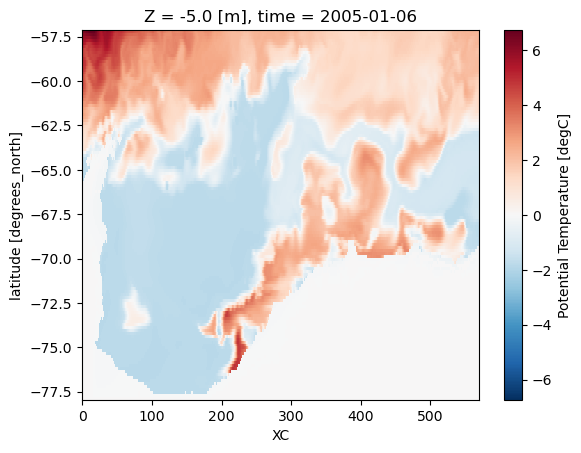

In [5]:
temp[0,0].drop('XC').plot();

In [6]:
salt_bins = np.linspace(31, 35, 100)
theta_bins = np.linspace(-2.5, 8, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = (coords_wg.hFacC * coords_wg.rA * coords_wg.drF)

In [7]:
vol.sum().values

array(2.8483568e+16, dtype=float32)

In [8]:
ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['XC', 'YC', 'Z']).rename({'THETA_bin':'theta_bin',
                                                                'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist

<xarray.DataArray 'histogram_THETA_SALT' (time: 438, theta_bin: 99, salt_bin: 99)>
dask.array<truediv, shape=(438, 99, 99), dtype=float32, chunksize=(1, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [9]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.mean(dim='time')

In [10]:
ts_hist_mean

<xarray.DataArray 'histogram_THETA_SALT' (theta_bin: 99, salt_bin: 99)>
dask.array<mean_agg-aggregate, shape=(99, 99), dtype=float32, chunksize=(99, 99), chunktype=numpy.ndarray>
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [11]:
ts_hist_mean.nbytes/1e9

3.9204e-05

In [12]:
#save to netcdf file
ts_hist_mean.to_netcdf('ts_hist_mean_SOSE.nc')

# Load in `ts_hist_mean_SOSE.nc` ds and plot

In [13]:
ts_hist_mean = xr.open_dataarray('ts_hist_mean_SOSE.nc')

In [14]:
ts_hist_mean

<xarray.DataArray 'histogram_THETA_SALT' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

Text(0, 0.5, 'Potential Temperature [˚C]')

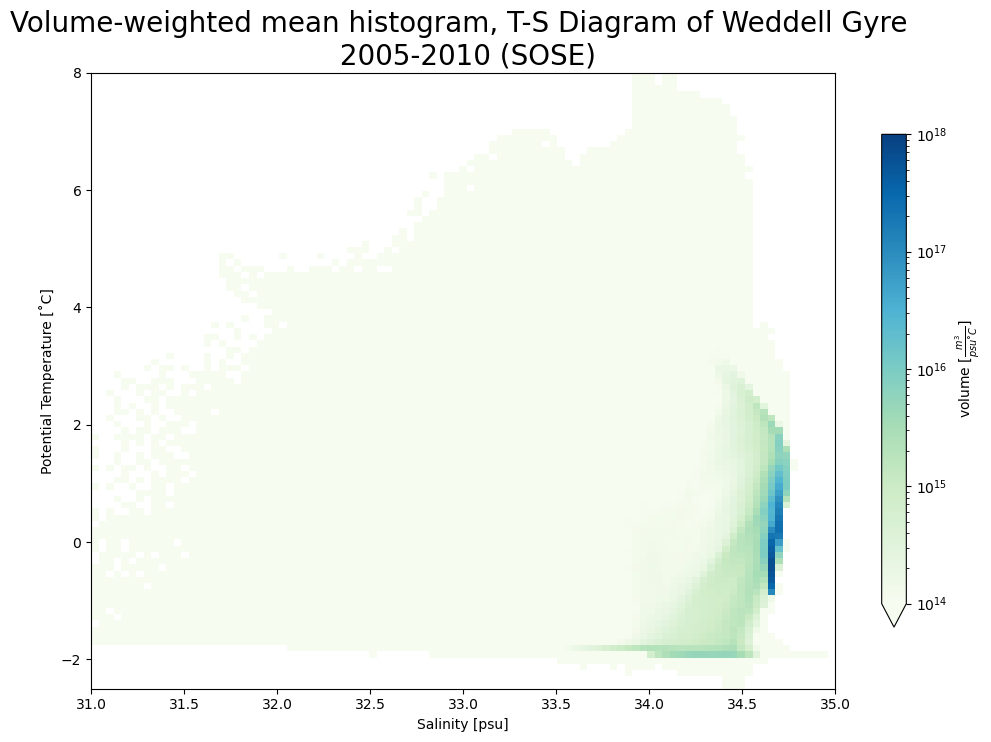

In [15]:
ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), figsize=(12,8), 
                                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                                        cmap='GnBu', vmin=1e14, vmax=1e18)

plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')

# Adding isopycnal contours
to xhistogram plot

In [16]:
import fastjmd95

In [18]:
sigma2 = fastjmd95.rho(ts_hist_mean.salt_bin, ts_hist_mean.theta_bin, 2000.)

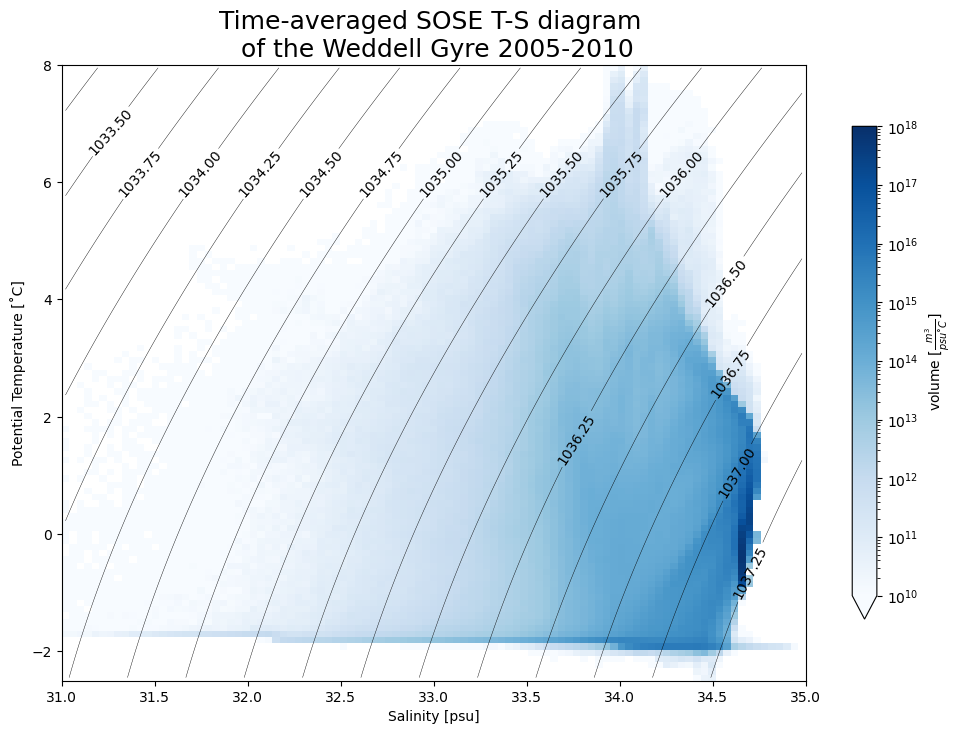

In [19]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.transpose().plot.contour(colors='k', levels=sigma_levs, linewidths=0.3, ax=ax)
plt.clabel(C)
hist = ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e10, vmax=1e18,
                                               cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Time-averaged SOSE T-S diagram \n of the Weddell Gyre 2005-2010', fontsize=18);

## Movie!

In [ ]:
def xhist_plot(dsr, fig, tt, salt=salt, temp=temp):

    salt = salt.isel(time=tt)#, **lat_range, **lon_range)
    temp = temp.isel(time=tt)#, **lat_range, **lon_range)
    #salt = dsr.SALT.isel(**lat_range, **lon_range)
    #temp = dsr.THETA.isel(**lat_range, **lon_range)

    pressure = xr.apply_ufunc(gsw.p_from_z, coords.Z, lat, output_dtypes=[coords.Z.dtype], dask='parallelized').reset_coords(drop=True)
    sa = xr.apply_ufunc(gsw.SA_from_SP, salt, pressure, lon, lat, output_dtypes=[salt.dtype], dask='parallelized').reset_coords(drop=True)
    sa.name = 'SA'
    ct = xr.apply_ufunc(gsw.CT_from_pt, sa, temp, output_dtypes=[temp.dtype], dask='parallelized').reset_coords(drop=True)
    ct.name = 'CT'
    
    #sa = sa.isel(time=tt)#, **lat_range, **lon_range)
    #ct = ct.isel(time=tt)#, **lat_range, **lon_range)
    
    sa_bins = np.linspace(31, 35, 100)
    ct_bins = np.linspace(-2.5, 8, 100)
    
    delta_sa = sa_bins[1] - sa_bins[0]
    delta_ct = ct_bins[1] - ct_bins[0]
    
    vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)
    

    
    #define sigma grid
    
    xdim_sa = np.arange(31, 35, 0.1)
    ydim_ct = np.arange(-2.5, 8, 0.1)
    
    sigma = np.empty([40, 105])
    for j in range(40):
        for i in range(105):
            sigma[j, i] = gsw.sigma2(xdim_sa[j], ydim_ct[i])
        
    #Plotting
    
    ax = fig.subplots()
    
    ts_hist = histogram(ct, sa, bins=[ct_bins, sa_bins],
                    weights=vol, dim=['XC', 'YC', 'Z']).rename({'CT_bin':'ct_bin',
                                                                'SA_bin':'sa_bin'}) / (delta_salt * delta_theta)
    
    C = ax.contour(xdim_salt, ydim_temp, sigma.T, colors='k', linewidths=0.5)
    ax.clabel(C)
    
    hist = ts_hist.where(ts_hist>0).plot(norm=LogNorm(), ax=ax, cmap='Blues', vmin=1e14, vmax=1e18,
                                         cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
  
    timestamp = str(dsr.time.isel(time=tt).values)
    ax.text(x=33,y=-4.2, s=timestamp[:10], 
            fontsize=18, weight='bold', horizontalalignment='center')
    
    ax.set_title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
    ax.set_xlabel('Absolute Salinity [g/kg]')
    ax.set_ylabel('Conservative Temperature [˚C]')

    fig.subplots_adjust(top=0.8)
    
    return ax, hist

In [ ]:
%matplotlib inline

In [ ]:
#creating movie object
mov = Movie(dsr.time, plotfunc=xhist_plot, 
            salt=salt, temp=temp, input_check=False, dpi=150)
#mov.save('movie.mp4')

In [ ]:
#frame preview
mov.preview(3)

In [ ]:
#frame preview
mov.preview(30)

In [ ]:
#frame preview
mov.preview(60)

In [ ]:
#create a movie!

#dsr = dsr.isel(time=slice(0,21))

mov = Movie(dsr.time, plotfunc=xhist_plot, 
            salt=salt, 
            temp=temp, 
            input_check=False, dpi=150)
mov.save('xhist_isopycnals_SOSE_Blues.mp4', progress=True)